In [79]:
#

import xbbg
import scipy
from scipy.interpolate import CubicSpline
from xbbg import blp
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.pyplot import plot
from matplotlib import pyplot as plt
import os
import matplotlib.ticker as plticker
import pandas_datareader as pdr
import matplotlib.ticker as mticker
#data
tickers = ['AA US Equity']#,'INTC US Equity']

start_date = datetime.today()- \
                        relativedelta(days = 2*252) #datetime.strptime(df.index[-10],'%d/%m/%Y')
#set end date (t)
end_date = datetime.today()#.strftime('%d/%m/%Y')
#ticker = str('TYA Comdty')
#lets do outright futures, swap spreads and future spreads
fut = blp.bdh(tickers=tickers
             , flds=['Px_last'],
             start_date= start_date, end_date=end_date,Per='D')
fut.index.names = ['date']
fut.index = fut.index#.strftime('%d/%m/%Y')
fut.columns = fut.columns.droplevel(1)
df = fut.copy()
df['daily_ret'] = df['AA US Equity'].diff()
df['pct_ret'] = df['daily_ret']/df['AA US Equity'].shift(1)

#5% move in day mean reversion signal triggers
#note 5% is hardcoded right now
df['signal'] = df.apply(lambda x : 1 if x['pct_ret']>= 0.05 else -1 if x['pct_ret']<= -0.05 else 0, axis = 1)


<AxesSubplot:xlabel='date'>

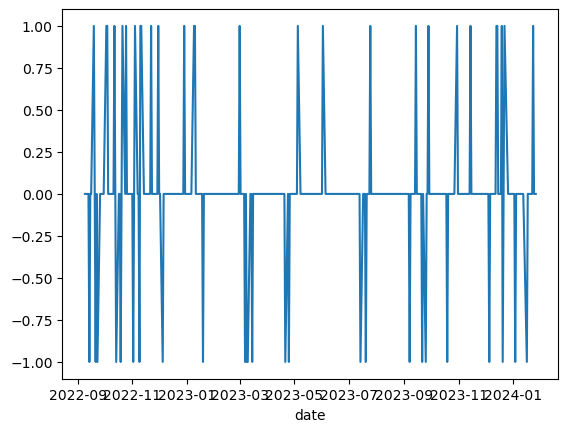

In [80]:
df['signal'].plot()

In [81]:

#volatility target the positions.
#calculate the rolling 20 day std
df['rolling_std']= df['pct_ret'].ewm(com = 20).std()

#set a target volatility... here we set the average
target_vol = df['rolling_std'].mean()

#set the leverage /position sizing to scale up or down to target vol
df['leverage_factor'] = target_vol/df['rolling_std']
#scale the entry positions by the leverage factor
df['scaled_signal']= df['signal']*df['leverage_factor']

<AxesSubplot:xlabel='date'>

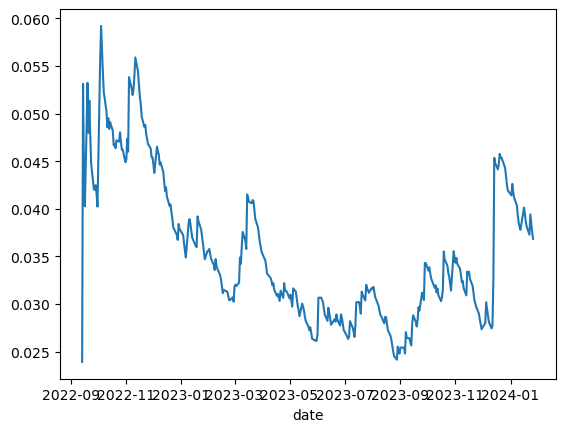

In [82]:
df['rolling_std'].plot()

<AxesSubplot:xlabel='date'>

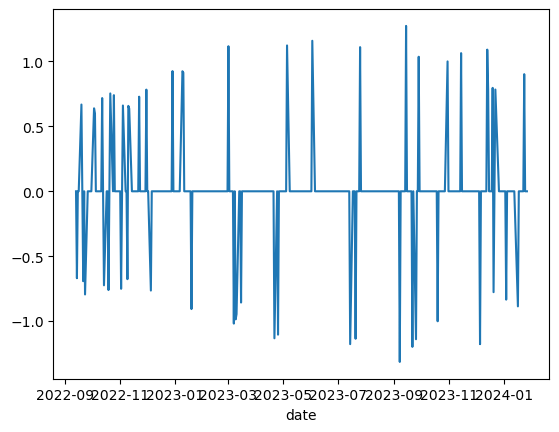

In [83]:
df['scaled_signal'].plot()

In [84]:
#set a holding_period, then we shift signals over that horizon and add to get overall active positioning
holding_period = 5

df_pos = df[['scaled_signal']].copy()
for i in range(1, holding_period):
    df_pos['scaled_signal_'+str(i)] = df_pos['scaled_signal'].shift(i)
df_pos.fillna(0,inplace = True)
df_pos['pos'] = df_pos.sum(axis=1)
df= pd.merge(df,df_pos[['pos']], how = 'left', left_index = True, right_index = True)

<AxesSubplot:xlabel='date'>

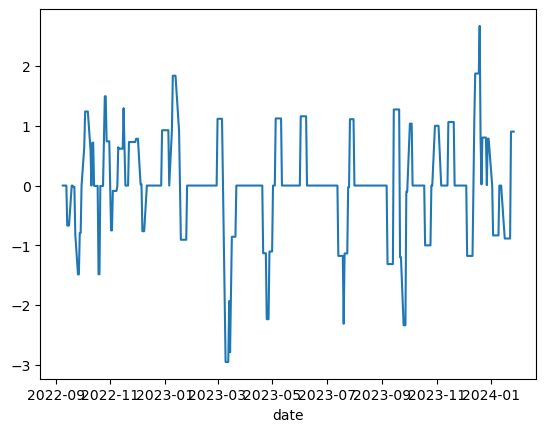

In [85]:
df_pos['pos'].plot()

<AxesSubplot:xlabel='date'>

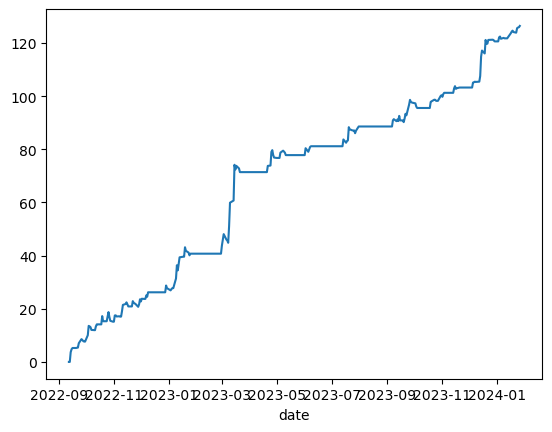

In [86]:
df['strategy_returns']= df['daily_ret']*df['pos']
df['strategy_returns'].cumsum().plot()

In [12]:
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
#import statsmodels.formula.api as sm
#import statsmodels.tsa.stattools as ts
#import statsmodels.tsa.vector_ar.vecm as vm
from scipy.stats.stats import pearsonr
for lookback in [1, 5, 10, 25, 60]:
    for holddays in [1, 5, 10, 25, 60]:
        ret_lag=df.pct_change(periods=lookback)
        ret_fut=df.shift(-holddays).pct_change(periods=holddays)
        if (lookback >= holddays):
            indepSet=range(0, ret_lag.shape[0], holddays)
        else:
            indepSet=range(0, ret_lag.shape[0], lookback)
            
        ret_lag=ret_lag.iloc[indepSet]
        ret_fut=ret_fut.iloc[indepSet]
        goodDates=(ret_lag.notna() & ret_fut.notna()).values
        (cc, pval)=pearsonr(np.squeeze(np.asarray(ret_lag[goodDates])), np.squeeze(np.asarray(ret_fut[goodDates])))
        print('%4i %4i %7.4f %7.4f' % (lookback, holddays, cc, pval))


   1    1  0.0476  0.3773
   1    5 -0.0311  0.5664
   1   10 -0.0806  0.1396
   1   25 -0.0948  0.0894
   1   60 -0.0506  0.3930
   5    1 -0.0197  0.7167
   5    5 -0.1249  0.3066
   5   10 -0.2511  0.0388
   5   25 -0.1490  0.2361
   5   60 -0.1430  0.2843
  10    1 -0.0884  0.1052
  10    5 -0.2225  0.0682
  10   10 -0.4078  0.0167
  10   25 -0.2723  0.1316
  10   60 -0.2175  0.2570
  25    1 -0.0901  0.1066
  25    5 -0.1163  0.3563
  25   10 -0.1478  0.4194
  25   25 -0.3691  0.2146
  25   60 -0.1585  0.6416
  60    1 -0.0178  0.7636
  60    5 -0.0778  0.5614
  60   10 -0.0750  0.6989
  60   25  0.0963  0.7781
  60   60 -0.3942  0.5114


C:\Users\chengc3\AppData\Local\Temp\ipykernel_33292\750485217.py:7: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


,AA US Equity,daily_ret,pct_ret
date,,,
2022-09-09,52.620,NaN,NaN
2022-09-12,52.340,-0.280,-0.005321
2022-09-13,50.290,-2.050,-0.039167
2022-09-14,44.810,-5.480,-0.108968
2022-09-15,43.140,-1.670,-0.037268
...,...,...,...
2024-01-22,27.620,0.260,0.009503
2024-01-23,29.510,1.890,0.068429
2024-01-24,29.760,0.250,0.008472
